In [1]:
import os
import pandas as pd
from skimage import transform
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from skimage import color
import time
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr

from CV_CNN_regressor.CV_CNN_regressor import ImageDataset, CNNRegressorCV, evaluate, get_feature

In [3]:
# Load data
image_tensors = []
number = []
image_folder = './CobaltImageDataset/cv_mixture_Co'  
for filename in os.listdir(image_folder):
    if filename.endswith('.png'):
        num = filename.split('.')[0]
        num = int(num)
        number.append(num)
        img = Image.open(os.path.join(image_folder, filename))
        img_array = np.array(img)
        
        if img_array.ndim == 3:
            if img_array.shape[2] == 4:
                rgb_img = color.rgba2rgb(img_array)
                gray_img = color.rgb2gray(rgb_img)
            elif img_array.shape[2] == 3:
                gray_img = color.rgb2gray(img_array)
            else:
                raise ValueError(f"Unsupported channel shape: {img_array.shape}")
        elif img_array.ndim == 2:
            gray_img = img_array  
        else:
            raise ValueError(f"Unsupported image shape: {img_array.shape}")
            
        new_size = (300, 300)
        resized_img = transform.resize(gray_img, new_size)
        img_tensor = torch.tensor(resized_img)
        img_tensor = torch.tensor(resized_img, dtype=torch.float32).unsqueeze(0)
        image_tensors.append(img_tensor)

df = pd.read_csv('./CobaltImageDataset/data_Co.csv')
target = df['yield'].to_list()
target = np.array(target)

num_csv = df['number_in_file'].to_list()
num_csv = np.array(num_csv)

target_dict = {}
for idx, y in zip(num_csv, target):
    target_dict[idx] = y

target_train = []
for i in number:
    y = target_dict[i]
    target_train.append(y)    
target_train = np.array(target_train)

dataset_f = ImageDataset(image_tensors, number, target_train)
data_loader_f = DataLoader(dataset_f, batch_size=10, shuffle=True)

In [7]:
# Model training
model = CNNRegressorCV()
criterion_r = nn.MSELoss()
optimizer_r = optim.Adam(model.parameters(),lr=0.001)
kf = KFold(n_splits=10, shuffle=True, random_state=0)

all_acc_list = []
all_loss_list = []
label_list = []
attention_list = []
attention2_list = []
atten_num_list = []
predict_list = []
val_indices_all = []
eval_num_list = []
fold_num = 1
for train_indices, val_indices in kf.split(dataset_f):
    
    t_ini = time.time()    
    train_dataset = [dataset_f[i] for i in train_indices]
    val_dataset = [dataset_f[i] for i in val_indices]
    val_indices_all.append(val_indices)

    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True) 
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)
    
    num_val_list = []
    acc_val_list= []
    loss_list = []
    for epoch in range(50):
        model.train()
        for image, num, label in train_loader:
            optimizer_r.zero_grad()
            output, _, _ = model(image)
            output = output.to(torch.float64)
            #label = label.view(-1)
            output = output.squeeze(1)
            loss = criterion_r(output, label)
            loss.backward()
            optimizer_r.step()
        label_val, prediction_val, num_val = evaluate(model, val_loader)
        attention_val, atten_num_val, attention2_val = get_feature(model, val_loader)
        loss = loss.detach()
        loss_list.append(loss)
        if epoch == 49:
            label_list.extend(label_val)
            predict_list.extend(prediction_val)
            attention_list.append(attention_val)
            attention2_list.append(attention2_val)
            atten_num_list.extend(atten_num_val)
            eval_num_list.extend(num_val)
    
    all_loss_list.append(loss_list[-1])
    t_fold = time.time()
    t = t_fold - t_ini
    t_min = t/60
    print(
        "Fold {:02d}, Loss {:.4f}, training time: {:.4f} minutes".format(
        fold_num, loss_list[-1], t_min)
        )
    fold_num += 1
    
label_np = np.array(label_list).astype(float)
predict_np = np.array(predict_list).astype(float)
pearson_r, _ = pearsonr(label_np, predict_np.squeeze())
mae = mean_absolute_error(label_list, predict_list)
average_loss = np.mean(all_loss_list)
print("Pearson R {:.4f}, MAE {:.4f}, Loss {:.4f}".format(pearson_r, mae, average_loss))

Fold 01, Loss 0.2221, training time: 1.4192 minutes
Fold 02, Loss 0.0032, training time: 1.3398 minutes
Fold 03, Loss 0.0004, training time: 1.3294 minutes
Fold 04, Loss 0.0000, training time: 1.2771 minutes
Fold 05, Loss 0.0031, training time: 1.2870 minutes
Fold 06, Loss 0.0004, training time: 1.7160 minutes
Fold 07, Loss 0.0022, training time: 1.3076 minutes
Fold 08, Loss 0.0001, training time: 1.3540 minutes
Fold 09, Loss 0.0000, training time: 1.4112 minutes
Fold 10, Loss 0.0003, training time: 1.3277 minutes
Pearson R 0.8911, MAE 0.0574, Loss 0.0232


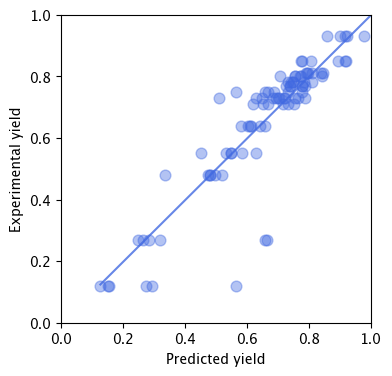

In [11]:
# Plot regression result
plt.figure(figsize=(4, 4), dpi=100)
plt.scatter(predict_list, label_list, color='royalblue', alpha=0.4, s=60)
predict_array = np.array(predict_list).flatten()
label_array = np.array(label_list)
coefficients = np.polyfit(predict_array, label_array, 1)
polynomial = np.poly1d(coefficients)
x_fit = np.linspace(min(predict_list), max(predict_list), 100)
y_fit = polynomial(x_fit)

plt.plot(x_fit, y_fit, color='royalblue', alpha=0.8)
plt.xlabel('Predicted yield')
plt.ylabel('Experimental yield')
plt.ylim(0,1)
plt.xlim(0,1)
plt.show()

[87]


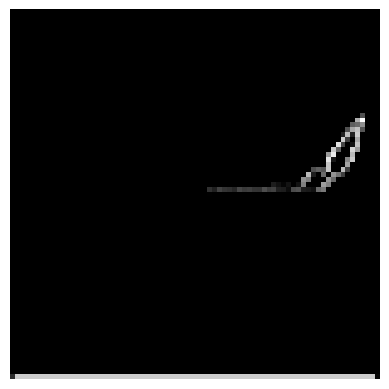

In [53]:
# Draw feature map of image number 1
attention2_stack_tensor = torch.stack([t for group in attention2_list for t in group])
arr = np.array(atten_num_list)
indices = np.where(arr == 1)[0]
print(indices)
array = attention2_stack_tensor[indices][0]
plt.imshow((array), cmap='gray')
plt.axis('off')
plt.show()